In [1]:
%matplotlib inline

In [2]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [3]:
# Root directory for dataset
dataroot = "./dataset"

# Number of workers for dataloader
workers = 2
# Batch size during training
batch_size = 128
# Spatial size of training images. All images will be resized to this
image_size = 64
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Number of training epochs
num_epochs = 250
# Learning rate for optimizers
lr = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
ngpu = 0

params = {
    "batch_size" : 128, # Training batch size
    'image_size' : 64,  # Imagesize, preprocess to this
    'nc' : 3,           # RGB
    'nz' : 100,         # Input latent vector
    'ngf' : 64,         # Number of generator filters/featurs
    'ndf' : 64,         # Number of discriminator filters/features
    'num_epochs' : 250,   # Number of training epochs.
    'lr' : 0.0002,      # Learning rate
    'beta1' : 0.5,      # First Decay rate Adam
    'save_epoch' : 2}   # Save every 2 epoch

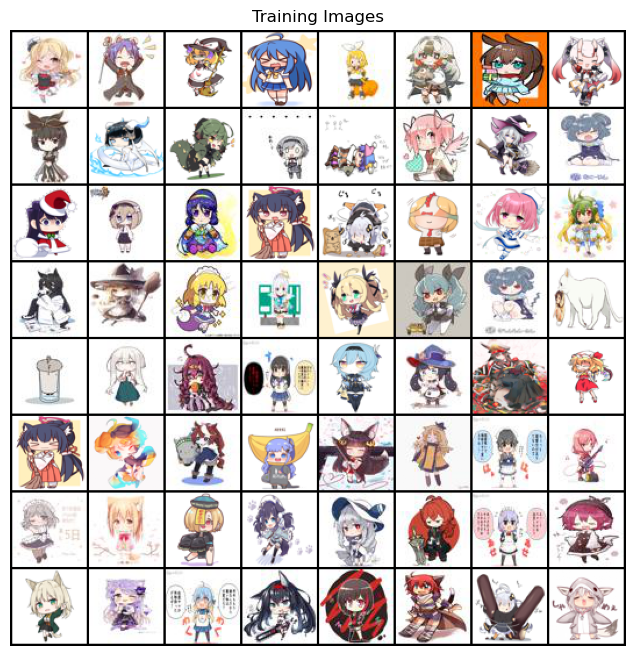

In [4]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("mps")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [5]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu, params):
        super(Generator, self).__init__()
        nz = params['nz']
        ngf = params['ngf']
        nc = params['nc']
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [7]:
# Create the generator
netG = Generator(ngpu, params=params).to(device)

# Handle multi-gpu if desired
if (device.type == 'mps') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


Discriminator Code



In [8]:
class Discriminator(nn.Module):
    def __init__(self, ngpu, params):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        nc = params['nc']
        ndf = params['ndf']
        
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [9]:
# Create the Discriminator
netD = Discriminator(ngpu, params=params).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [10]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [11]:
print(device)

mps


In [12]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################################################

        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/250][0/21]	Loss_D: 1.7888	Loss_G: 6.1715	D(x): 0.6616	D(G(z)): 0.6573 / 0.0033
[1/250][0/21]	Loss_D: 0.2181	Loss_G: 13.2828	D(x): 0.9158	D(G(z)): 0.0000 / 0.0000
[2/250][0/21]	Loss_D: 4.2074	Loss_G: 17.7988	D(x): 0.9569	D(G(z)): 0.9620 / 0.0000
[3/250][0/21]	Loss_D: 2.2946	Loss_G: 9.9393	D(x): 0.9624	D(G(z)): 0.8273 / 0.0002
[4/250][0/21]	Loss_D: 0.5556	Loss_G: 4.6007	D(x): 0.8782	D(G(z)): 0.3069 / 0.0141
[5/250][0/21]	Loss_D: 1.6049	Loss_G: 7.7692	D(x): 0.8665	D(G(z)): 0.7072 / 0.0007
[6/250][0/21]	Loss_D: 0.8234	Loss_G: 7.1035	D(x): 0.9071	D(G(z)): 0.4791 / 0.0012
[7/250][0/21]	Loss_D: 0.2650	Loss_G: 3.8416	D(x): 0.8309	D(G(z)): 0.0527 / 0.0253
[8/250][0/21]	Loss_D: 1.9180	Loss_G: 13.3951	D(x): 0.9770	D(G(z)): 0.8243 / 0.0000
[9/250][0/21]	Loss_D: 0.4646	Loss_G: 5.9522	D(x): 0.8744	D(G(z)): 0.2126 / 0.0041
[10/250][0/21]	Loss_D: 0.7484	Loss_G: 1.7975	D(x): 0.6224	D(G(z)): 0.1090 / 0.2459
[11/250][0/21]	Loss_D: 0.5278	Loss_G: 3.7866	D(x): 0.8389	D(G(z)): 0

[99/250][0/21]	Loss_D: 0.1790	Loss_G: 4.1616	D(x): 0.8968	D(G(z)): 0.0618 / 0.0235
[100/250][0/21]	Loss_D: 0.3613	Loss_G: 4.1808	D(x): 0.9612	D(G(z)): 0.2492 / 0.0211
[101/250][0/21]	Loss_D: 0.2810	Loss_G: 2.8427	D(x): 0.8350	D(G(z)): 0.0827 / 0.0806
[102/250][0/21]	Loss_D: 0.5004	Loss_G: 1.4047	D(x): 0.7062	D(G(z)): 0.0965 / 0.3131
[103/250][0/21]	Loss_D: 0.2969	Loss_G: 3.5664	D(x): 0.8826	D(G(z)): 0.1369 / 0.0377
[104/250][0/21]	Loss_D: 0.2861	Loss_G: 3.8848	D(x): 0.8915	D(G(z)): 0.1414 / 0.0306
[105/250][0/21]	Loss_D: 0.2721	Loss_G: 2.7316	D(x): 0.8371	D(G(z)): 0.0767 / 0.0940
[106/250][0/21]	Loss_D: 0.3223	Loss_G: 2.8162	D(x): 0.8912	D(G(z)): 0.1660 / 0.0898
[107/250][0/21]	Loss_D: 0.3266	Loss_G: 2.0664	D(x): 0.8172	D(G(z)): 0.0989 / 0.1614
[108/250][0/21]	Loss_D: 0.4450	Loss_G: 4.1768	D(x): 0.9754	D(G(z)): 0.3164 / 0.0217
[109/250][0/21]	Loss_D: 0.3834	Loss_G: 3.7274	D(x): 0.9147	D(G(z)): 0.2320 / 0.0332
[110/250][0/21]	Loss_D: 0.3127	Loss_G: 2.3691	D(x): 0.7819	D(G(z)): 0.0417 / 

[197/250][0/21]	Loss_D: 0.4933	Loss_G: 2.4287	D(x): 0.7022	D(G(z)): 0.0670 / 0.1666
[198/250][0/21]	Loss_D: 0.0988	Loss_G: 4.5257	D(x): 0.9853	D(G(z)): 0.0761 / 0.0181
[199/250][0/21]	Loss_D: 0.1722	Loss_G: 4.1226	D(x): 0.9664	D(G(z)): 0.1200 / 0.0240
[200/250][0/21]	Loss_D: 0.0479	Loss_G: 5.7882	D(x): 0.9816	D(G(z)): 0.0277 / 0.0069
[201/250][0/21]	Loss_D: 0.0747	Loss_G: 4.0838	D(x): 0.9931	D(G(z)): 0.0635 / 0.0260
[202/250][0/21]	Loss_D: 0.0945	Loss_G: 4.5825	D(x): 0.9905	D(G(z)): 0.0781 / 0.0132
[203/250][0/21]	Loss_D: 0.0534	Loss_G: 4.6274	D(x): 0.9810	D(G(z)): 0.0327 / 0.0159
[204/250][0/21]	Loss_D: 0.0627	Loss_G: 4.1117	D(x): 0.9751	D(G(z)): 0.0355 / 0.0279
[205/250][0/21]	Loss_D: 0.0478	Loss_G: 4.3861	D(x): 0.9851	D(G(z)): 0.0314 / 0.0206
[206/250][0/21]	Loss_D: 0.0479	Loss_G: 4.6437	D(x): 0.9753	D(G(z)): 0.0221 / 0.0148
[207/250][0/21]	Loss_D: 0.1552	Loss_G: 5.2619	D(x): 0.9959	D(G(z)): 0.1311 / 0.0072
[208/250][0/21]	Loss_D: 0.0512	Loss_G: 4.6660	D(x): 0.9950	D(G(z)): 0.0441 /

In [15]:
torch.save(netD.state_dict(), './netD.pth')
torch.save(netD.state_dict(), './netG.pth')

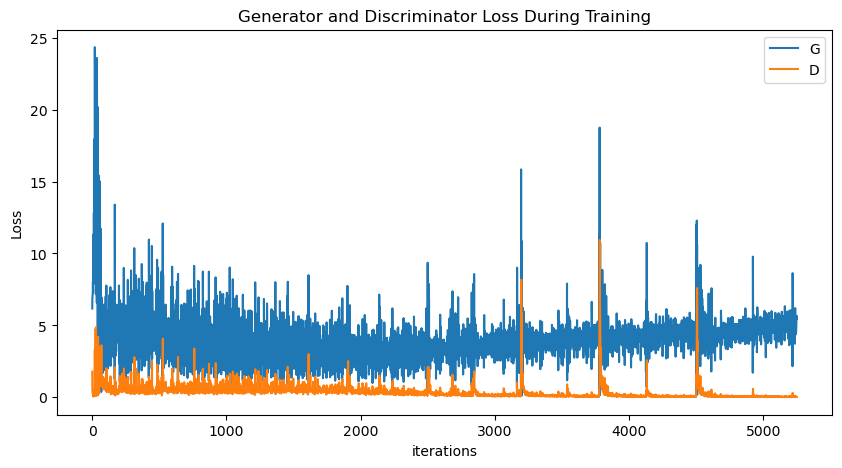

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

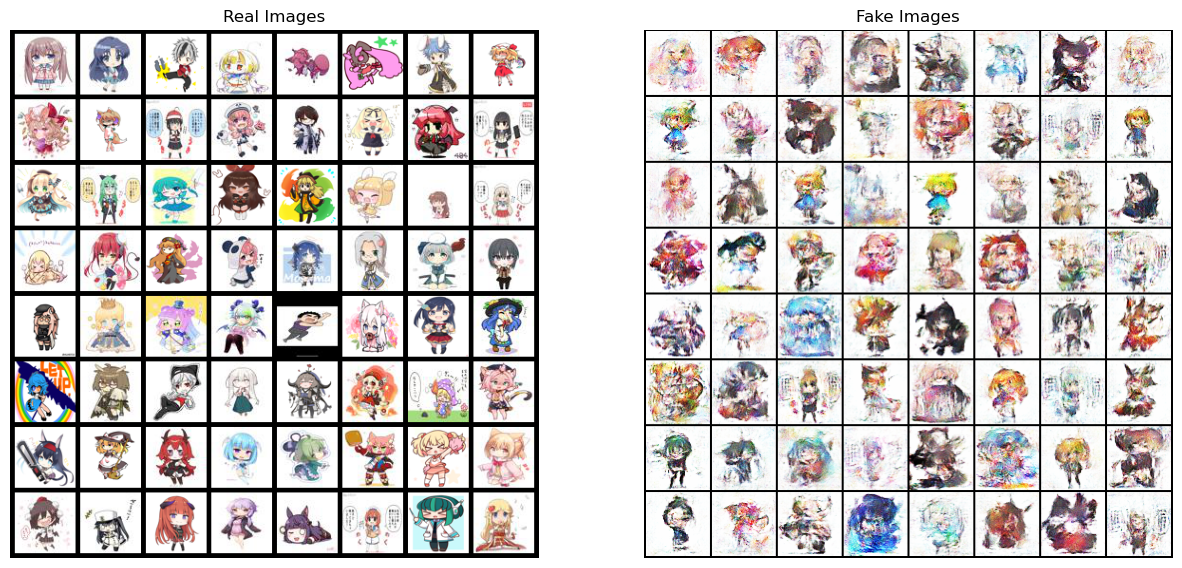

In [14]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()